In [5]:
#Implementación LDA Algoritmo LDA.

#Modelo vector Bag of Words (términos de la frecuencia), en vez de tf-idf como en Non Negative Matrix 
#Modelo generativo LDA tien más sentido que los componentes sea la frecuencia de los términos

import pandas as pd
import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import pickle
import numpy as np

In [6]:
##########################
#SET DE FUNCIONES COMUNES#
##########################

import os
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
import pandas as pd

def interpret_topics(n_componentes,algoritmo,vectorial_object):
    #Interpretacion de los tópicos
    diccionario_topics = {}
    vocabulary = {item:key for key,item in  vectorial_object.vocabulary_.items()}
    
    for componente in range(n_componentes):
      lista_ordenada = sorted(range(algoritmo.components_.shape[1]),reverse = True,key = lambda x: algoritmo.components_[componente][x])[:10]
      print(f'Topic {componente +1 }: \n')
      print(lista_ordenada)
      temas_topic = ', '.join(vocabulary[i] for i in lista_ordenada)
      print(temas_topic)
      diccionario_topics.update({componente:temas_topic})
      print('\n')
      
      
    return diccionario_topics,vocabulary

def export_json_topics(algoritmo,diccionario_topics):

    directorio_destino_topics = 'topics/'
    with open(os.path.join(directorio_destino_topics,f'topics_{algoritmo}.json'),'w',encoding='utf8') as f:
        json.dump(diccionario_topics, f, indent= 2,ensure_ascii=False)

    f.close()


    
def sentence_corrector(diccionario, language):
    diccionario_corregido = {}
    for key in range(len(diccionario.keys())):
        print(key)
        print(diccionario[key])
        speller = SpellChecker(language=language)
        
        values = diccionario[key]
        values = [i.strip() for i in values ]
        print(values)
        
        list_correct_words = [speller.correction(word) if speller.correction(word) is not None else word for word in values ]
        diccionario_corregido[key]= list_correct_words
    return diccionario_corregido


def worcloud_topics(n_componentes,algoritmo,vocabulary,file_name):
    #Wordclouds
    
    wc_atributos = {
        'height':800,
        'width':1200,
        'background_color':'white',
        'max_words' : 20
        }
    
    fig,axs = plt.subplots(n_componentes,figsize = (6,20))
    
    
    for n in range(n_componentes):
        lista_ordenada = sorted(range(algoritmo.components_.shape[1]),reverse = True,key = lambda x: algoritmo.components_[n][x])[:10]
        print(lista_ordenada)
        compt_dict = {vocabulary[i]: algoritmo.components_[n][i] for i in lista_ordenada}
        wc = WordCloud(**wc_atributos).generate_from_frequencies(compt_dict)
        
        axs[n].set_title(f'Tópico {n+1}')
        axs[n].imshow(wc)
        axs[n].axis('off')
        
    plt.savefig('image_topics/wc_topics_'+file_name+'.png')
    plt.show()


def distribution_topics(bow,predominant_topics,algorithm):
    # Crear un DataFrame para mostrar los resultados
    df_results = pd.DataFrame({
        'Documento': range(bow.shape[0]),
        'Tema Dominante': predominant_topics
    })
    
  
    df_results['Tema Dominante'] = df_results['Tema Dominante'].apply(lambda x: x+1)

    topic_counts = df_results['Tema Dominante'].value_counts()
     
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    topic_counts.plot(kind='bar')
    plt.xlabel('Tema')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de aparición de cada tema')
    plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario
    plt.savefig('image_topics/'+algorithm+'_distribution_topics.png')
    plt.show()
    
def serializar_lista(lista,name):
    try:
        lista_to_serie = pd.Series(lista)
        lista_to_serie.to_pickle(name+'.pkl')
        print('Los tópicos se han asignado correctamente')
    except:
        print('NO se ha posido serializar la lista de asignación correctamente')

In [7]:
components = 10
stopwords = nltk.corpus.stopwords.words('english')

data = pd.read_csv('data/data_sentiment_analisis.csv',index_col=None)

In [8]:
lda = LatentDirichletAllocation(
    n_components = components,
    learning_method='online',
    learning_decay = 0.5,
    max_iter = 100,
    batch_size = 10,
    random_state = 123
)

bow_object = CountVectorizer(
    max_df = 0.7, #Eliminar términos que aparezcan con una frecuencia superior a f (en este caso 70%)
    stop_words = stopwords
)

bow = bow_object.fit_transform(data['review_preprocesada'])

x_lda = lda.fit_transform(bow)

In [9]:
#Construir el vocabulario y detectar las palabras más influyentes en cada tópico
diccionario_topics,vocabulary = interpret_topics(components,lda,bow_object)

# Identificar el tópico predominante para cada documento
predominant_topics = np.argmax(x_lda, axis=1)
serializar_lista(lista=predominant_topics,name='asig_topics/topics_asig_lda')

Topic 1: 

[22041, 25303, 6107, 16344, 2234, 1711, 6048, 19020, 3059, 7570]
run, system, cool, minute, around, almost, control, pick, beat, die


Topic 2: 

[10951, 20746, 24585, 11637, 20861, 10968, 17269, 11589, 15262, 9910]
game, really, story, great, recommend, gamelan, nice, graphic, look, feel


Topic 3: 

[10822, 2726, 12154, 10807, 24564, 2143, 26277, 21486, 28270, 26139]
fun, back, hates, full, stop, arcade, track, rest, water, ton


Topic 4: 

[10951, 19234, 11200, 28384, 15564, 11380, 16842, 15314, 25832, 9291]
game, play, get, well, make, go, much, lot, thing, even


Topic 5: 

[9792, 15696, 14969, 16610, 14815, 28134, 2777, 12512, 4619, 1285]
far, map, life, money, leave, wait, bad, hit, cat, act


Topic 6: 

[22601, 3372, 10139, 17802, 21625, 15912, 1727, 9910, 14387, 10103]
see, bit, first, one, review, mechanic, also, feel, keep, finish


Topic 7: 

[11439, 26001, 10951, 19826, 12077, 28811, 10702, 19846, 9301, 15245]
good, time, game, pretty, hard, worth, friend, price

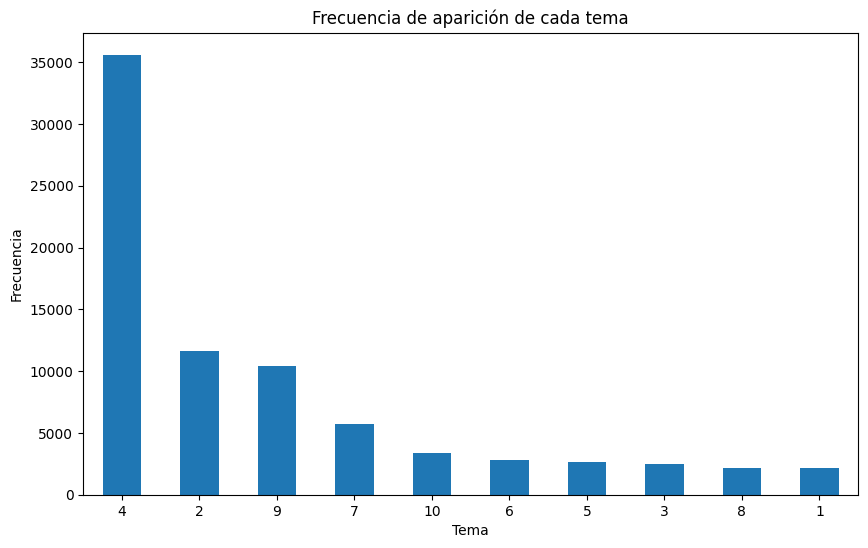

[22041, 25303, 6107, 16344, 2234, 1711, 6048, 19020, 3059, 7570]
[10951, 20746, 24585, 11637, 20861, 10968, 17269, 11589, 15262, 9910]
[10822, 2726, 12154, 10807, 24564, 2143, 26277, 21486, 28270, 26139]
[10951, 19234, 11200, 28384, 15564, 11380, 16842, 15314, 25832, 9291]
[9792, 15696, 14969, 16610, 14815, 28134, 2777, 12512, 4619, 1285]
[22601, 3372, 10139, 17802, 21625, 15912, 1727, 9910, 14387, 10103]
[11439, 26001, 10951, 19826, 12077, 28811, 10702, 19846, 9301, 15245]
[14912, 15564, 1253, 26642, 12148, 23872, 5663, 12349, 7486, 11278]
[20306, 4268, 7581, 10086, 19245, 4847, 8965, 2944, 23212, 20453]
[17152, 28753, 15695, 27628, 4091, 22610, 14086, 16524, 16813, 22285]


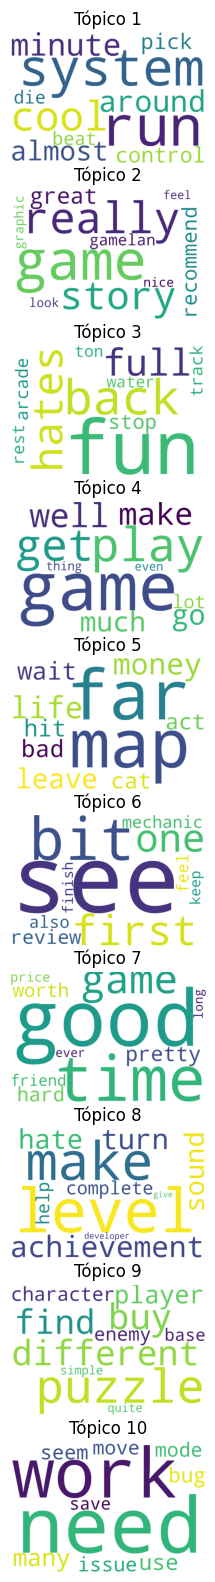

Modelo serializado correctamente


In [10]:
#Ver la distribución de los documentos a los tópicos a los que se asigna
distribution_topics(bow,predominant_topics,algorithm='lda_algorithm')

worcloud_topics(n_componentes=components,algoritmo=lda,vocabulary=vocabulary,file_name = 'lda')

export_json_topics('lda',diccionario_topics)


#Serializamos la matriz W

with open('model_serialization/x_lda.pkl','wb') as file:
    try:
        pickle.dump(x_lda, file)
        print('Modelo serializado correctamente')
    except:
        print('El modelo no ha sido capaz de serializarse')
file.close()